In [0]:
import array
import gzip
import itertools
import numpy
import numpy.random as npr
import os
import struct
import time
from os import path
import urllib.request

import jax.numpy as np
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
from jax import random

The following cell contains boilerplate code to download and load MNIST data.

In [0]:
_DATA = "/tmp/"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(create_outliers=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  test_images = _partial_flatten(test_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if create_outliers:
    mum_outliers = 30000
    perm = numpy.random.RandomState(0).permutation(mum_outliers)
    train_images[:mum_outliers] = train_images[:mum_outliers][perm]

  return train_images, train_labels, test_images, test_labels

def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels

train_images, train_labels, test_images, test_labels = mnist(create_outliers=False)
num_train = train_images.shape[0]

The following cell defines the accuracy of our model and how to initialize its parameters. 

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

def init_random_params(layer_sizes, rng=npr.RandomState(0)):
  scale = 0.1
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

In [0]:
batch_size = 50
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()

In [0]:
from jax.experimental import optimizers
from jax.experimental import stax

In [0]:
init_random_params, predict = stax.serial(
    stax.Conv(256, (5,5),strides = (2,2)),
    stax.Relu,
    stax.Conv(128, (3,3)),
    stax.Relu,
    stax.Conv(32, (3,3)),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Flatten,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(10),
)

We redefine the cross-entropy loss for this model. As done in Problem 1, complete the return line below (it's identical). 

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.sum(targets*preds)/len(targets)

Next, we define the mini-batch SGD optimizer, this time with the optimizers library in JAX. 

In [0]:
learning_rate = 0.08
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

The next cell contains our training loop, very similar to Problem 1. 

learning rate, batch size, number
of epochs

In [9]:
num_epochs = 20

key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))
opt_state = opt_init(init_params)
itercount = itertools.count()

acc_list=[]
for epoch in range(1, num_epochs + 1):
  for _ in range(num_batches):
    opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

  params = get_params(opt_state)
  test_acc = accuracy(params, shape_as_image(test_images, test_labels))
  test_loss = loss(params, shape_as_image(test_images, test_labels))
  print('Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(test_loss, 100 * test_acc))
  acc_list.append(test_acc)

Test set loss, accuracy (%): (0.05, 98.54)
Test set loss, accuracy (%): (0.03, 98.84)
Test set loss, accuracy (%): (0.03, 98.93)
Test set loss, accuracy (%): (0.04, 98.66)
Test set loss, accuracy (%): (0.03, 99.00)
Test set loss, accuracy (%): (0.04, 98.90)
Test set loss, accuracy (%): (0.03, 99.16)
Test set loss, accuracy (%): (0.03, 99.22)
Test set loss, accuracy (%): (0.04, 98.95)
Test set loss, accuracy (%): (0.03, 99.17)
Test set loss, accuracy (%): (0.04, 99.13)
Test set loss, accuracy (%): (0.03, 99.15)
Test set loss, accuracy (%): (0.03, 99.16)
Test set loss, accuracy (%): (0.03, 99.15)
Test set loss, accuracy (%): (0.04, 99.19)
Test set loss, accuracy (%): (0.03, 99.32)
Test set loss, accuracy (%): (0.04, 99.30)
Test set loss, accuracy (%): (0.04, 99.34)
Test set loss, accuracy (%): (0.04, 99.34)
Test set loss, accuracy (%): (0.04, 99.32)


# Assignment 5

## question1

In [0]:
class_7_label = [0.,0.,0.,0.,0.,0.,0.,1.,0.,0.]
index_class7 = test_labels.tolist().index(class_7_label)
input_image, input_label = shape_as_image(test_images[index_class7], test_labels[index_class7])

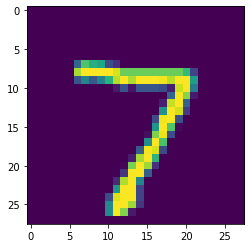

In [11]:
#original image visulization
from matplotlib import pyplot as plt
visualize_image = input_image
visualize_image = np.reshape(visualize_image, (28,28))
plt.imshow(visualize_image, interpolation='nearest')

In [0]:
epsilon = 0.3

In [0]:
def loss_adversarial(params, inputs, target):
  logits = predict(params, inputs)
  preds = stax.logsoftmax(logits)
  return -np.sum(target*preds)/len(target)

grad_inputx = grad(loss_adversarial,1)(params, input_image, input_label)
#test_loss = loss_adversarial(params, shape_as_image(test_images[index_class7], test_labels[index_class7]))

In [0]:
#finding perturbation
x_star = input_image + epsilon * np.sign(grad_inputx)

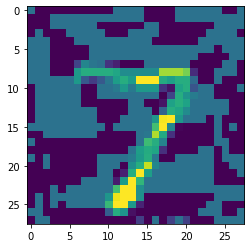

In [15]:
#visualization of the perturbed image
visualize_image = x_star
visualize_image = np.reshape(visualize_image, (28,28))
plt.imshow(visualize_image, interpolation='nearest')

In [16]:
#prediction vector on original image
original_vector = predict(params, input_image)
print("original image prediction vector:",original_vector)
print("original image prediction class is:",np.argmax(input_label))

original image prediction vector: [[-10.591128    3.242197   -2.06981     5.1399255   5.895992   -8.595505
  -17.238644   31.00107    -6.7674303   6.42636  ]]
original image prediction class is: 7


In [17]:
#prediction vector on perturbed image
prediction=predict(params, x_star)
print("perturbed image prediction vector:\n",prediction)
print("\n")
print("perturbed image prediction class is:",np.argmax(prediction))

perturbed image prediction vector:
 [[ -8.468346    -0.44819298  -2.3158536    2.9975183    6.421769
   -4.1822863  -10.618071     4.271467     0.768729    11.091545  ]]


perturbed image prediction class is: 9


## question 2

In [0]:
image = test_images[0:1000]
label = test_labels[0:1000]
input_image_q2, input_label_q2 = shape_as_image(image, label)
grad_inputx = grad(loss_adversarial,1)(params, input_image_q2, input_label_q2)

In [0]:
accuracy_result= []
epsilon = np.arange(0,1,0.01)
for i in epsilon: 

  #update input
  x_star = input_image_q2 + i * np.sign(grad_inputx)
  #calculate accuracy
  test_acc = accuracy(params, shape_as_image(x_star, label))
  accuracy_result.append(test_acc)

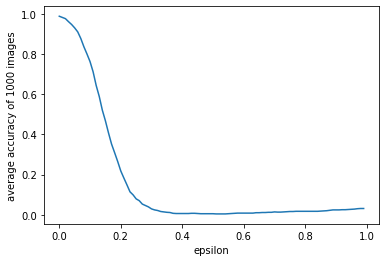

In [29]:
#plot
plt.plot(epsilon, accuracy_result)
plt.xlabel("epsilon")
plt.ylabel("average accuracy of 1000 images")
plt.show()

## question 3

In [0]:
class_7_label = [0.,0.,0.,0.,0.,0.,0.,1.,0.,0.]
index_class7 = test_labels.tolist().index(class_7_label)
input_image, input_label = shape_as_image(test_images[index_class7], test_labels[index_class7])

In [0]:
#finding perturbation
k=5
epsilon=0.3
original_image = input_image
for _ in range (k):
  grad_inputx = grad(loss_adversarial,1)(params, original_image, input_label)
  original_image = original_image + epsilon/k * np.sign(grad_inputx)

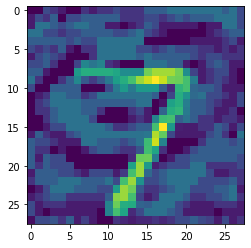

In [23]:
#visualization of the perturbed image
visualize_image = original_image
visualize_image = np.reshape(visualize_image, (28,28))
plt.imshow(visualize_image, interpolation='nearest')

In [24]:
#prediction vector on original image
print("original image prediction class is:",np.argmax(input_label))
original_vector = predict(params, input_image)
print("original image prediction vector:",original_vector)

original image prediction class is: 7
original image prediction vector: [[ -6.252203    1.5817097  -3.5154386   2.4587338   4.4790573  -8.702801
  -16.247257   28.22652    -7.763813    5.988873 ]]


In [25]:
#prediction vector on perturbed image
prediction=predict(params, original_image)
print("perturbed image prediction vector:\n",prediction)
print("\n")
print("perturbed image prediction class is:",np.argmax(prediction))

perturbed image prediction vector:
 [[ -7.270721   -7.402145   -8.604808    5.975889    5.25399     1.1150608
  -18.148315    3.550653    0.6232727  25.983038 ]]


perturbed image prediction class is: 9


## question 4

In [0]:
image = test_images[0:1000]
label = test_labels[0:1000]
input_image_q4, input_label_q4 = shape_as_image(image, label)

In [0]:
accuracy_result= []
k=5
epsilon = np.arange(0,2,0.01).tolist()
original_image = input_image_q4
for e in epsilon: 

  for _ in range (k):
    grad_inputx = grad(loss_adversarial,1)(params, original_image, input_label_q4)
    original_image = original_image + e/k * np.sign(grad_inputx)

    #calculate accuracy
  test_acc = accuracy(params, shape_as_image(original_image, label))
  accuracy_result.append(test_acc)

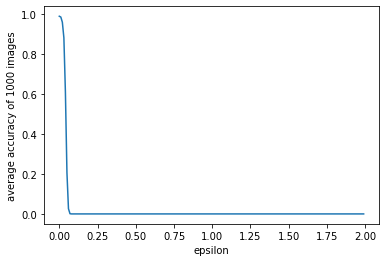

In [28]:
#plot
plt.plot(epsilon, accuracy_result)
plt.xlabel("epsilon")
plt.ylabel("average accuracy of 1000 images")
plt.show()